In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prepared-data/Prepared_Data.pkl


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gensim
from gensim.models import KeyedVectors

In [4]:
df = pd.read_pickle("/kaggle/input/prepared-data/Prepared_Data.pkl")
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,index,CATEGORY,TEXT,OUTPUT_LABEL
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,48470.0,Discharge summary,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,4782.0,Discharge summary,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,24476.0,Discharge summary,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,57341.0,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,34829.0,Discharge summary,Admission Date: [**2178-4-16**] ...,0


In [5]:
df.TEXT = df.TEXT.fillna(' ')
df.TEXT = df.TEXT.str.replace('\n',' ')
df.TEXT = df.TEXT.str.replace('\r',' ')
df.TEXT = df.TEXT.str.lower()
df.TEXT = df.TEXT.str.replace(r'[^a-zA-Z\s]', '', regex=True)
df.TEXT = df.TEXT.str.replace(r'\s+', ' ', regex=True)
df.TEXT = df.TEXT.str.strip()

In [6]:
df_filtered = df[['SUBJECT_ID', 'HADM_ID', 'TEXT', 'OUTPUT_LABEL']]
X = df_filtered['TEXT']
y = df_filtered['OUTPUT_LABEL']

df_filtered['OUTPUT_LABEL'].value_counts()


OUTPUT_LABEL
0    48109
1     3004
Name: count, dtype: int64

In [7]:
df_0 = df_filtered[df_filtered['OUTPUT_LABEL'] == 0]
df_0.shape

(48109, 4)

In [8]:
df_1 = df_filtered[df_filtered['OUTPUT_LABEL'] == 1]
df_1.shape

(3004, 4)

In [9]:
df_0_downsampled = df_0.sample(df_1.shape[0])
df_0_downsampled.shape

(3004, 4)

In [10]:
df_balanced = pd.concat([df_0_downsampled, df_1])
df_balanced.head()

,SUBJECT_ID,HADM_ID,TEXT,OUTPUT_LABEL
36864,30266,134204,name known lastname known firstname unit no nu...,0
52476,79600,169524,admission date discharge date date of birth se...,0
10909,8918,152345,admission date discharge date service medicine...,0
17254,14092,115595,,0
57169,94422,164964,admission date discharge date date of birth se...,0


In [11]:
df_balanced['OUTPUT_LABEL'].value_counts()

OUTPUT_LABEL
0    3004
1    3004
Name: count, dtype: int64

In [12]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced[['TEXT']], df_balanced['OUTPUT_LABEL'], test_size=0.2, random_state=42)

In [14]:
Val_X_train, Val_X_test, Val_y_train, Val_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [15]:
print(f"Train samples: {len(Val_X_train)}")  # Should be ~3,844
print(f"Validation samples: {len(Val_X_test)}")  # Should be ~962
print(f"Test samples: {len(X_test)}")  # Should be ~1,202


Train samples: 3844
Validation samples: 962
Test samples: 1202


In [16]:
!pip install transformers

In [17]:
from transformers import BertTokenizerFast, AutoModel


bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [18]:
tokens_train = tokenizer.batch_encode_plus(
    X_train['TEXT'].tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation = True
)


In [19]:
token_val = tokenizer.batch_encode_plus(
    Val_X_train['TEXT'].tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

In [20]:
token_test = tokenizer.batch_encode_plus(
    X_test['TEXT'].tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

In [21]:
import torch

In [22]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

In [23]:
val_seq = torch.tensor(token_val['input_ids'])
val_mask = torch.tensor(token_val['attention_mask'])
val_y = torch.tensor(Val_y_train.tolist())

In [24]:
test_seq = torch.tensor(token_test['input_ids'])
test_mask = torch.tensor(token_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

In [26]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [27]:
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [28]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [29]:
print(f"Train samples: {len(train_data)}")  # Should match len(Val_X_train)
print(f"Validation samples: {len(val_data)}")  # Should match len(Val_X_test)
print(f"Test samples: {len(test_data)}")  # Should match len(X_test)

print(f"Train batches: {len(train_dataloader)}")  
print(f"Validation batches: {len(val_dataloader)}")  
print(f"Test batches: {len(test_dataloader)}")  


Train samples: 4806
Validation samples: 3844
Test samples: 1202
Train batches: 301
Validation batches: 241
Test batches: 76


In [30]:
for param in bert.parameters():
  param.requires_grad = False

In [31]:
import torch.nn as nn

In [32]:
import torch
import torch.nn as nn

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        outputs = self.bert(sent_id, attention_mask=mask, return_dict=True)
        
        cls_hs = outputs.last_hidden_state[:, 0, :]  # Extract CLS token properly
        
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x


In [33]:
model = BERT_Arch(bert)

In [34]:
import torch

if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
model = model.to(device)

In [37]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [39]:
print(class_weights)

[1.00501882 0.99503106]


In [40]:
weights = torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)

cross_entropy = nn.NLLLoss(weight=weights)
epochs = 10

In [41]:
def train():

  model.train()
  total_loss, total_accuracy = 0, 0

  total_preds=[]

  for step, batch in enumerate(train_dataloader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    model.zero_grad()

    preds = model(sent_id, mask)

    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    preds = preds.detach().cpu().numpy()

  total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [42]:
import time

def format_time(seconds):
    """Converts a time in seconds into a string in the format h:m:s"""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def evaluate():
  print("\nEvaluating...")


  t0 = time.time()
  model.eval()

  total_loss, total_accuracyy = 0,0
  total_preds = []

  for step,batch in enumerate(val_dataloader):

    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():

      preds = model(sent_id, mask)

      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)
  
  avg_loss = total_loss / len(val_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [43]:
import torch

input_ids_tensor = torch.tensor(tokens_train['input_ids'])
attention_mask_tensor = torch.tensor(tokens_train['attention_mask'])

print(f"Input IDs shape: {input_ids_tensor.shape}")
print(f"Attention Mask shape: {attention_mask_tensor.shape}")


Input IDs shape: torch.Size([4806, 512])
Attention Mask shape: torch.Size([4806, 512])


In [44]:
best_valid_loss = float('inf')

epochs = 15

train_losses = []
valid_losses = []

for epoch in range(epochs):

  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

  train_loss, _ = train()

  valid_loss, _ = evaluate()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_weights.pt')

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    301.
  Batch   100  of    301.
  Batch   150  of    301.
  Batch   200  of    301.
  Batch   250  of    301.
  Batch   300  of    301.

Evaluating...
  Batch    50  of    241.
  Batch   100  of    241.
  Batch   150  of    241.
  Batch   200  of    241.

Training Loss: 0.695
Validation Loss: 0.690

 Epoch 2 / 15
  Batch    50  of    301.
  Batch   100  of    301.
  Batch   150  of    301.
  Batch   200  of    301.
  Batch   250  of    301.
  Batch   300  of    301.

Evaluating...
  Batch    50  of    241.
  Batch   100  of    241.
  Batch   150  of    241.
  Batch   200  of    241.

Training Loss: 0.692
Validation Loss: 0.687

 Epoch 3 / 15
  Batch    50  of    301.
  Batch   100  of    301.
  Batch   150  of    301.
  Batch   200  of    301.
  Batch   250  of    301.
  Batch   300  of    301.

Evaluating...
  Batch    50  of    241.
  Batch   100  of    241.
  Batch   150  of    241.
  Batch   200  of    241.

Training Loss: 0.690
Validation Loss: 0

In [45]:
model_path = 'saved_weights.pt'


In [46]:
model.load_state_dict(torch.load(model_path))

<ipython-input-46-10f2805df5d4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [47]:
model.eval()

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [48]:
device = torch.device("cpu")  # Force CPU
model = model.to(device)  # Move model to CPU

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))  # Ensure tensors are on CPU
    preds = preds.cpu().numpy()  # No need for .detach() since no gradients are tracked


In [49]:
preds = np.argmax(preds, axis=1)

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y,preds)
print(cm)

[[361 252]
 [270 319]]


Text(50.722222222222214, 0.5, 'Truth')

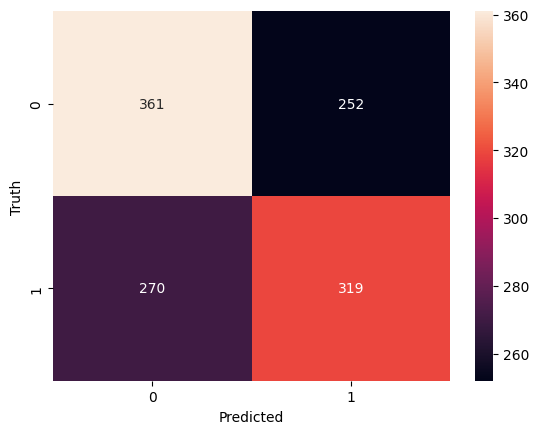

In [51]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [52]:
import torch
import shap
import numpy as np
from transformers import AutoTokenizer

# Set device (CPU)
device = torch.device("cpu")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load trained model and move to CPU
model = BERT_Arch(torch.load(model_path, map_location=device))  # Use your existing model path
model = model.to(device)
model.eval()  # Ensure evaluation mode

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


BERT_Arch(
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [65]:
text = "Patient discharged with stable vitals, follow-up in 2 weeks."

In [66]:
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

In [67]:
inputs

{'input_ids': tensor([[  101,  5776, 14374,  2007,  6540,  8995,  2015,  1010,  3582,  1011,
          2039,  1999,  1016,  3134,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}